# 林先輩が[Re:tech](http://dryer.wsl.mind.meiji.ac.jp:3000/articles/62)に出していた問題を解いてみる。
条件は以下の通り。

In [1]:
# coding:utf-8
import numpy as np
import random
from GridMDP import *
import copy
import numpy as np, pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

# -1が壁、0が道、1がゴール
MAZE = [[-1,-1,-1,-1,-1,-1,-1,-1,-1,-1],
                [-1, 0, 0, 0, 0, 0, 0, 0, 0,-1],
                [-1,-1,-1,-1,-1, 0,-1,-1, 0,-1],
                [-1,-1, 0, 0, 0, 0, 0,-1, 0,-1],
                [-1, 0,-1,-1,-1,-1,-1,-1, 0,-1],
                [-1, 0, 0, 0, 0, 0, 0, 0, 0,-1],
                [-1, 0,-1,-1,-1,-1,-1,-1, 0,-1],
                [-1, 0, 0, 0, 0, 0, 0, 0, 0,-1],
                [-1,-1, 0,-1,-1,0,-1,-1,-1,-1],
                [-1,-1, 0, 0, 0, 0, 0, 0, 0,-1],
                [-1,-1,-1,-1, 0,-1,-1,-1,-1,-1],
                [-1,-1, 0, 0, 0, 0, 0, 0, 100,-1],
                [-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]]

START  = (1, 1) #開始地点(固定)
GOAL   = (len(MAZE)-2,len(MAZE[0])-2)  #ゴール地点（固定）
ACTION = [(-1, 0), (1, 0), (0, -1), (0, 1)] # [上, 下, 左, 右]
EPOCH  = 1000 #何世代やるか
GAMMA   = 0.95 #割引率
EPSIL  = 0.1 # ε-greedyのやつ
RESULT = []

### 自分の実装要件に合うようにちょっと書き換え。  
壁扱いの所を、-1からNoneに変更している。  
GridMDPは迷路用のマルコフ遷移モデル  
実行すると、表形式で見れる。

In [2]:
for y in range(len(MAZE)):
    for x in range(len(MAZE[0])):
        if MAZE[y][x] == -1:
            MAZE[y][x] = None
        

mdp = GridMDP(MAZE, terminals = [GOAL], init=START)

df = pd.DataFrame(mdp.grid)
df.style.highlight_null(null_color="Black")

---
まず、Q-Leaningの軽い説明から。
## QLearningとは
QLearningとは、ある状態sの下で行動aを選択する価値Q(s,a)を学習する方法。  
価値反復法では遷移確率がわかっている前提で動くが、チェスや将棋ではそんなものはわからない。そこで出てくるのがQLearning.
## QLearningの軸
試行錯誤によりあるsの下で様々な行動aを取り、その時の報酬と遷移後の状態を使って、正しいQ(s,a)を学習していく。  
以下の更新式が軸となる。

\begin{align}
Q(s_t,a_t) \gets Q(s_t,a_t) + \alpha(r_{t+1}+\gamma\max_{\substack{a}}Q(s_{t+1},a)-Q(s_t,a_t)) \\
\end{align}
γは割引率（0.9-0.99がよく用いられる）、αは学習率（0.1がよく用いられる）

#### 図にすると以下のよう
<img src="https://cloud.githubusercontent.com/assets/17490886/25703083/0cd1eef0-310f-11e7-8f6a-bf443fccef1a.png" width = 600px>

### つまり、ある状態におけるある行動の価値を、それによる次の状態における最良の行動の価値に近づけることがQ-Learningの狙い

### QLearningのアルゴリズム
1. 全ての状態と取りうる行動(s,a)の組みについて、初期のQ(s,a)をランダムに決める。
1. 状態を最初の状態s_0にセット。t=0とする（１）
1. 状態s_tからある方法で行動a_tを選択し、定義に基づきQ(s,a)を更新。  状態はs,t+1に移行。(2)
1. (2)を一定回数行ったら、sを最初状態s_0に戻す。(3)
1. (2)と(3)のセットを一定数行ったら終了。

---
実装は以下から
# QLearningクラス
GridMDPクラスを受け取り、QLearningを行うクラス。  
### 変数self.Q
全ての状態sと行動aについてQ(s,a)を辞書式で格納する。  
Q(s,a)は{(s,a):value,(s,a):value,..}というような形式。  
引数のmdpを用いて、Qを調整して行く形。  

## 流れ
1. まずインスタンス化。__init__でself.Qはランダムに初期化される。  
    アルゴリズムにおける1に相当。
1. 呼び出し側では、学習させたい回数Q.learn()メソッドを呼び出す。  
    アルゴリズムにおける5に相当。
1. learnメソッドで1エピソード分の学習を行う。1エピソードとは、s_0からゴールにたどり着くまで。  
    1エピソードが長くなりすぎないように、何回行動したら、終了とするべきだろう。  
    アルゴリズムにおける3-4に相当。

In [5]:
class QLearning():
    """Q学習を行うクラス"""
    
    def __init__(self,mdp,alpha=0.01,greedy_ratio = 0.2,gamma = 0.95):
        """初期化。全ての状態sと行動aについてQ(s,a)を初期化する。
        Q(s,a)は{(s,a):value,(s,a):value,..}というような形式。
        """
        self.Q = {}
        for s in mdp.states:
            for a in mdp.actions(s):
                self.Q[s,a] = random.uniform(1,10)
        self.alpha = alpha
        self.mdp = mdp
        self.greedy_ratio = greedy_ratio
        self.gamma = gamma
        
    def learn(self,max_epoch = 100):
        """1エピソードを消化して学習を行う。
        ある程度行動したら、失敗としてreturnする。"""
        #  状態を最初の状態s0にセット。
        state = self.mdp.init
        count = 0# ゴールにたどり着くまでにかかった行動回数。
        while True:
            #print(state)
            #状態s_tからある方法で行動a_tを選択。ε-greedyを用いる。
            action = self.action_e_greedy(state)
            #選択した行動から、Q(s,a)を更新
            self.update_Qvalue(state,action)
            #次状態へ以降
            state = self.mdp.go(state,action)
            count += 1
            if state in mdp.terminals:# ゴール。エピソードを終了。
                return count,True
            elif count >= max_epoch:
                return count,False
        
        
    def update_Qvalue(self,state,action):
        """sにおいて選択した行動aから、Q(s,a)を更新"""
        # 更新式:
        #       Q(s, a) <- Q(s, a) + alpha * {r(s, a) + gamma max{Q(s`, a`)} -  Q(s,a)}
        #               Q(s, a): 状態sにおける行動aを取った時のQ値      Q_s_a
        #               r(s, a): 状態sにおける報酬      r_s_a
        #               max{Q(s`, a`) 次の状態s`が取りうる行動a`の中で最大のQ値 mQ_s_a)
        Q_s_a = self.get_Qvalue(state,action)#状態sにおける行動aを取った時のQ値  
        n_state = self.mdp.go(state,action)#次状態next_stateを取得
        r_s_a = self.mdp.R(state,action)#状態sで行動aを取った時の報酬R(s,a)
        
        # 次状態n_stateが取りうる行動n_actionの中で最大のQ値を求める
        mQ_ns_a = max([self.get_Qvalue(n_state,n_action) for n_action in self.mdp.actions(n_state)])
        
        # calculate
        q_value = Q_s_a + self.alpha * ( r_s_a +  self.gamma * mQ_ns_a - Q_s_a)
        
        # update
        self.set_Qvalue(state,action,q_value)
        
    def get_Qvalue(self,state,action):
        """Q(s,a)を取得。"""
        try:
            return self.Q[state,action]
        except KeyError:
            print("Q({0},{1})のKeyIndexError".format(state,action))
            raise
            # return 0.0
    
    def set_Qvalue(self,state,action,q_value):
        """Q値に値を代入する"""
        self.Q[state,action] = q_value
            
    def action_e_greedy(self,state):
        """ε-greedy法で行動を決定"""
        if self.greedy_ratio > random.random():
            #ランダムに行動選択
            return random.choice(self.mdp.actions(state))
        else:
            #greedyに行動選択
            return self.action_greedy(state)
    
    def action_greedy(self,state):
        """Q(s,a)を比較してgreedy法で行動を決定。"""
        best_actions = []  #最高の行動が複数存在した場合
        max_q_value = -1 #最大の行動価値を保存
        for a in self.mdp.actions(state):#すごく単純な最大求めるやつ
            q_value = self.get_Qvalue(state,a)
            if q_value > max_q_value:
                best_actions = [a,]
                max_q_value = q_value
            elif q_value == max_q_value:
                best_actions.append(a)
        return random.choice(best_actions)#Q値の最大値が複数存在する場合はその中からランダムに選択。
    
    def printPi(self):
        print("実行結果")
        state =  self.mdp.init
        count = 0
        
        grid = copy.copy(self.mdp.grid)#コピー
        
        while True:
            action = self.action_greedy(state)# greedyに最適なactionを選択
            n_state = self.mdp.go(state,action) # 次状態に以降
            print(state,toArrow(action),n_state)
            #pprint(grid)
            grid[state[0]][state[1]] = toArrow(action)
            
            state = n_state
            count += 1
            if state in mdp.terminals:# ゴール。エピソードを終了。
                break
            if count > 100:#100回移動してゴールに行かなければ収束していないことの表れ
                print("収束していないようです")
                break
                
        return pd.DataFrame(grid).style.highlight_null(null_color="Black")

# Q-Learning実行
以下のコードを実行すれば、実行結果が表示されるはずです。  
mdpは前述で定義。

In [119]:
# if __name__ == '__main__':
#     q = QLearning(mdp)
#     LearningCount = 10000
#     # この分だけエピソードを繰り返して学習
#     for i in range(LearningCount):
#         q.learn()
#     display(q.printPi())

実行結果
(1, 1) → (1, 2)
(1, 2) → (1, 3)
(1, 3) → (1, 4)
(1, 4) → (1, 5)
(1, 5) → (1, 6)
(1, 6) → (1, 7)
(1, 7) → (1, 8)
(1, 8) ↓ (2, 8)
(2, 8) ↓ (3, 8)
(3, 8) ↓ (4, 8)
(4, 8) ↓ (5, 8)
(5, 8) ↓ (6, 8)
(6, 8) ↓ (7, 8)
(7, 8) ← (7, 7)
(7, 7) ← (7, 6)
(7, 6) ← (7, 5)
(7, 5) ← (7, 4)
(7, 4) ← (7, 3)
(7, 3) ← (7, 2)
(7, 2) ↓ (8, 2)
(8, 2) ↓ (9, 2)
(9, 2) → (9, 3)
(9, 3) → (9, 4)
(9, 4) ↓ (10, 4)
(10, 4) ↓ (11, 4)
(11, 4) → (11, 5)
(11, 5) → (11, 6)
(11, 6) → (11, 7)
(11, 7) → (11, 8)


# Q-Learning実行(探索回数の確認)
グラフで、各エピソードでどれだけ行動したかを確認してみる

実行結果
(1, 1) → (1, 2)
(1, 2) → (1, 3)
(1, 3) → (1, 4)
(1, 4) → (1, 5)
(1, 5) → (1, 6)
(1, 6) → (1, 7)
(1, 7) → (1, 8)
(1, 8) ↓ (2, 8)
(2, 8) ↓ (3, 8)
(3, 8) ↓ (4, 8)
(4, 8) ↓ (5, 8)
(5, 8) ↓ (6, 8)
(6, 8) ↓ (7, 8)
(7, 8) ← (7, 7)
(7, 7) ← (7, 6)
(7, 6) ← (7, 5)
(7, 5) ↓ (8, 5)
(8, 5) ↓ (9, 5)
(9, 5) ← (9, 4)
(9, 4) ↓ (10, 4)
(10, 4) ↓ (11, 4)
(11, 4) → (11, 5)
(11, 5) → (11, 6)
(11, 6) → (11, 7)
(11, 7) → (11, 8)


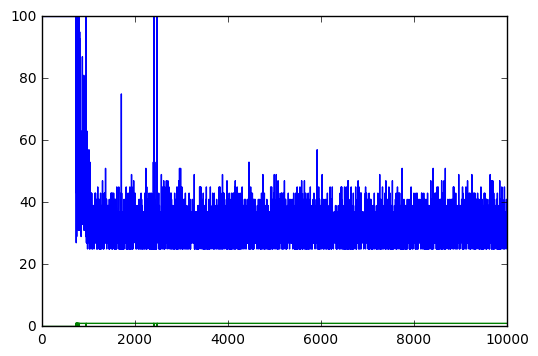

In [7]:
if __name__ == '__main__':
    q = QLearning(mdp)
    counts = []
    LearningCount = 10000
    # この分だけエピソードを繰り返して学習
    for i in range(LearningCount):
        counts.append(q.learn())
    display(q.printPi())
    plt.plot(np.array(counts))
    plt.show()